# Flame Evolution

Load extracted isocontours in a chosen snapshot range and plot them every `PLOT_EVERY` snapshots.

In [1]:
from __future__ import annotations
from pathlib import Path
import os

os.chdir("../../..")

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from FLAME.io_fronts import Case, load_fronts


In [15]:
PROJECT_ROOT = Path.cwd().resolve()
CONFIG_PATH = PROJECT_ROOT / "notebooks" / "case_studies" / "DMD" / "DMD.yaml"
GLOBAL_PLOT_STYLE_PATH = PROJECT_ROOT / "notebooks" / "case_studies" / "plot_style.yaml"
PLOT_STYLE_CFG = yaml.safe_load(GLOBAL_PLOT_STYLE_PATH.read_text(encoding="utf-8")) if GLOBAL_PLOT_STYLE_PATH.exists() else {}
LOCAL_CFG = yaml.safe_load(CONFIG_PATH.read_text(encoding="utf-8"))
CFG = dict(PLOT_STYLE_CFG)
CFG.update(LOCAL_CFG)

DATA_BASE_DIR = PROJECT_ROOT / Path("data/isocontours")
PHI = float(CFG["PHI"])
LAT_SIZE = str(CFG["LAT_SIZE"])
POST = bool(CFG["POST"])
MULTIPLE_RUNS = bool(CFG.get("MULTIPLE_RUNS", False))
N_RUN = int(CFG.get("N_RUN", 0))

# --- User controls ---
SNAPSHOT_START = 200
SNAPSHOT_END = 300
PLOT_EVERY = 1

# Plot options
ISOLEVEL_TO_PLOT = 0.6
POINT_SIZE = 8
POINT_ALPHA = 0.65

if PLOT_EVERY <= 0:
    raise ValueError("PLOT_EVERY must be > 0")
if SNAPSHOT_END < SNAPSHOT_START:
    raise ValueError("SNAPSHOT_END must be >= SNAPSHOT_START")

SNAPSHOTS = list(range(SNAPSHOT_START, SNAPSHOT_END + 1, PLOT_EVERY))
print(f"Using snapshots: {SNAPSHOTS[:5]} ... {SNAPSHOTS[-5:] if len(SNAPSHOTS) > 5 else SNAPSHOTS}")
print(f"Isolevels: {[ISOLEVEL_TO_PLOT]}")

# Model_verification-like plotting style
PLOT_FONT_FAMILY = str(CFG.get("PLOT_FONT_FAMILY", "CMU Serif"))
PLOT_FONT_SIZE = int(CFG.get("PLOT_FONT_SIZE", 20))
FIG_DPI = int(CFG.get("FIG_DPI", 250))
FIG_SIZE_RAW = CFG.get("FIG_SIZE", (6.8, 6.2))
if isinstance(FIG_SIZE_RAW, (list, tuple)) and len(FIG_SIZE_RAW) == 2:
    FIG_SIZE = (float(FIG_SIZE_RAW[0]), float(FIG_SIZE_RAW[1]))
else:
    FIG_SIZE = (6.8, 6.2)

PLOT_USE_TEX = bool(CFG.get("PLOT_USE_TEX", False))
PLOT_TEX_PREAMBLE_RAW = CFG.get("PLOT_TEX_PREAMBLE", "")
if isinstance(PLOT_TEX_PREAMBLE_RAW, (list, tuple)):
    PLOT_TEX_PREAMBLE = "\n".join(str(item) for item in PLOT_TEX_PREAMBLE_RAW if item)
else:
    PLOT_TEX_PREAMBLE = str(PLOT_TEX_PREAMBLE_RAW) if PLOT_TEX_PREAMBLE_RAW is not None else ""

def apply_plot_style() -> None:
    params = {
        "font.family": PLOT_FONT_FAMILY,
        "font.size": PLOT_FONT_SIZE,
        "axes.titlesize": PLOT_FONT_SIZE,
        "axes.labelsize": PLOT_FONT_SIZE,
        "xtick.labelsize": PLOT_FONT_SIZE,
        "ytick.labelsize": PLOT_FONT_SIZE,
        "legend.fontsize": max(PLOT_FONT_SIZE - 5, 9),
        "figure.titlesize": PLOT_FONT_SIZE,
        "axes.linewidth": 1.2,
        "text.usetex": PLOT_USE_TEX,
        "figure.subplot.left": 0.14,
        "figure.subplot.right": 0.86,
        "figure.subplot.bottom": 0.14,
        "figure.subplot.top": 0.96,
    }
    if PLOT_TEX_PREAMBLE:
        params["text.latex.preamble"] = PLOT_TEX_PREAMBLE
    plt.rcParams.update(params)

def style_axes(ax, *, equal: bool = False) -> None:
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle="-", linewidth=0.75, alpha=0.25)
    ax.grid(True, which="minor", linestyle="-", linewidth=0.25, alpha=0.15)
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)
    ax.tick_params(axis="both", which="major", length=6, width=1.0)
    ax.tick_params(axis="both", which="minor", length=3, width=0.8)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    if equal:
        ax.set_aspect("equal", adjustable="box")

apply_plot_style()

COLOR_DATA = str(CFG.get("COLOR_DATA", "#77b5b6"))
COLOR_DATA_EDGE = str(CFG.get("COLOR_DATA_EDGE", "#378d94"))
SCATTER_LINEWIDTH = float(CFG.get("SCATTER_LINEWIDTH", 0.05))



Using snapshots: [200, 201, 202, 203, 204] ... [296, 297, 298, 299, 300]
Isolevels: [0.6]


In [16]:
def make_case(time_step: int) -> Case:
    base_kwargs = dict(
        base_dir=DATA_BASE_DIR,
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=time_step,
        post=POST,
    )
    try:
        return Case(
            **base_kwargs,
            multiple_runs=MULTIPLE_RUNS,
            n_run=N_RUN,
        )
    except TypeError:
        return Case(**base_kwargs)


def load_fronts_for_snapshots(snapshots: list[int], isolevels: list[float]) -> dict[int, dict[float, pd.DataFrame]]:
    data: dict[int, dict[float, pd.DataFrame]] = {}
    for t in snapshots:
        case_t = make_case(t)
        try:
            data[t] = load_fronts(case_t, isolevels, required_cols=["x", "y"])
        except FileNotFoundError as exc:
            print(f"[WARN] Skipping snapshot {t}: {exc}")
    return data


front_data = load_fronts_for_snapshots(SNAPSHOTS, [ISOLEVEL_TO_PLOT])
print(f"Loaded {len(front_data)} snapshots.")


Loaded 101 snapshots.


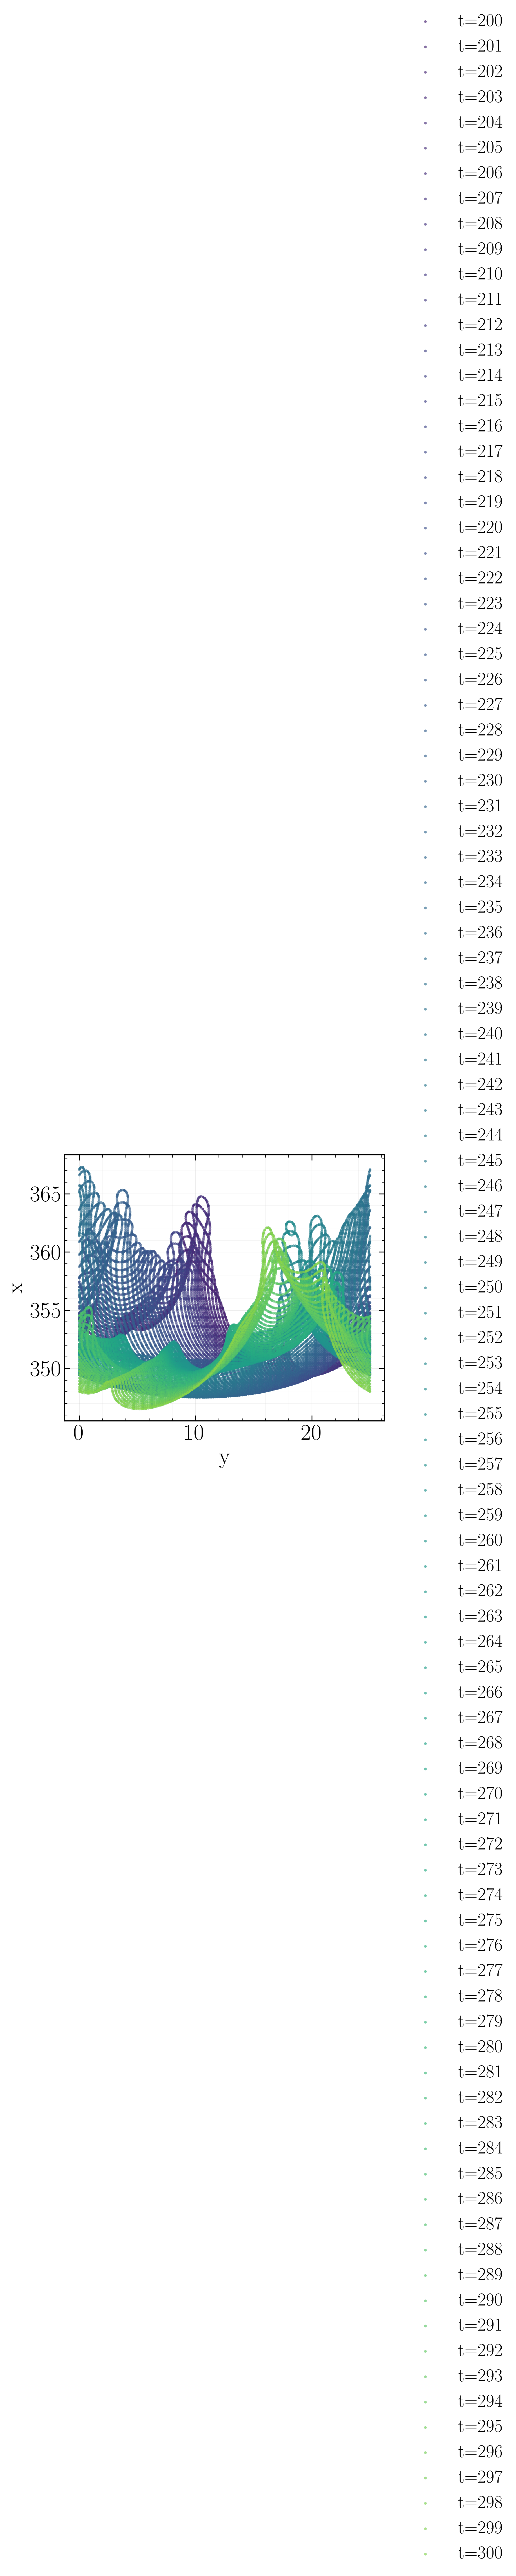

In [17]:
# Combined evolution plot for one selected isolevel (color = snapshot)
fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=False)

times = sorted(front_data)
colors = plt.cm.viridis(np.linspace(0.08, 0.82, max(len(times), 1)))
for color, t in zip(colors, times):
    df = front_data[t].get(float(ISOLEVEL_TO_PLOT))
    if df is None:
        continue
    ax.scatter(
        df["y"],
        df["x"],
        s=POINT_SIZE,
        alpha=POINT_ALPHA,
        color=color,
        edgecolors=COLOR_DATA_EDGE,
        linewidths=SCATTER_LINEWIDTH,
        label=f"t={t}",
        zorder=3,
    )

ax.set_xlabel("y")
ax.set_ylabel("x")
style_axes(ax, equal=True)
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.show()



In [ ]:
# Plot extracted isocontours separately and assemble a flame-front evolution video
from IPython.display import Video, Image, display
import imageio.v2 as imageio

FPS = 10
VIDEO_OUT_DIR = PROJECT_ROOT / "report_figures" / "case_studies" / "DMD" / "flame_evolution"
FRAMES_DIR = VIDEO_OUT_DIR / f"frames_iso{ISOLEVEL_TO_PLOT:g}_t{SNAPSHOT_START}_{SNAPSHOT_END}_s{PLOT_EVERY}"
VIDEO_STEM = f"flame_front_iso{ISOLEVEL_TO_PLOT:g}_t{SNAPSHOT_START}_{SNAPSHOT_END}_s{PLOT_EVERY}"
VIDEO_PATH = VIDEO_OUT_DIR / f"{VIDEO_STEM}.mp4"
GIF_PATH = VIDEO_OUT_DIR / f"{VIDEO_STEM}.gif"

VIDEO_OUT_DIR.mkdir(parents=True, exist_ok=True)
FRAMES_DIR.mkdir(parents=True, exist_ok=True)

times = sorted(front_data)
if not times:
    raise RuntimeError("No fronts loaded. Run the loading cell first and check snapshot/isolevel settings.")

# Keep fixed limits so the flame motion is visible without camera jumps.
all_x = np.concatenate([front_data[t][float(ISOLEVEL_TO_PLOT)]["x"].to_numpy() for t in times if float(ISOLEVEL_TO_PLOT) in front_data[t]])
all_y = np.concatenate([front_data[t][float(ISOLEVEL_TO_PLOT)]["y"].to_numpy() for t in times if float(ISOLEVEL_TO_PLOT) in front_data[t]])
if all_x.size == 0 or all_y.size == 0:
    raise RuntimeError(f"No contour points found for isolevel {ISOLEVEL_TO_PLOT}.")

x_pad = 0.03 * max(float(all_x.max() - all_x.min()), 1e-12)
y_pad = 0.03 * max(float(all_y.max() - all_y.min()), 1e-12)
xlim = (float(all_y.min() - y_pad), float(all_y.max() + y_pad))
ylim = (float(all_x.min() - x_pad), float(all_x.max() + x_pad))

frame_paths = []
for i, t in enumerate(times):
    df = front_data[t].get(float(ISOLEVEL_TO_PLOT))
    if df is None or df.empty:
        continue

    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=False)
    ax.scatter(
        df["y"],
        df["x"],
        s=POINT_SIZE,
        alpha=POINT_ALPHA,
        color=COLOR_DATA,
        edgecolors=COLOR_DATA_EDGE,
        linewidths=SCATTER_LINEWIDTH,
        zorder=3,
    )
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    ax.set_title(f"t={t}")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    style_axes(ax, equal=True)

    frame_path = FRAMES_DIR / f"frame_{i:04d}_t{t}.png"
    fig.savefig(frame_path, dpi=FIG_DPI, bbox_inches="tight")
    plt.close(fig)
    frame_paths.append(frame_path)

if not frame_paths:
    raise RuntimeError("No frames were generated.")

try:
    with imageio.get_writer(VIDEO_PATH, fps=FPS, codec="libx264") as writer:
        for frame_path in frame_paths:
            writer.append_data(imageio.imread(frame_path))
    print(f"Saved video: {VIDEO_PATH}")
    display(Video(str(VIDEO_PATH), embed=True))
except Exception as exc:
    print(f"[WARN] MP4 encoding failed ({exc}). Writing GIF instead.")
    with imageio.get_writer(GIF_PATH, mode="I", duration=1.0 / FPS) as writer:
        for frame_path in frame_paths:
            writer.append_data(imageio.imread(frame_path))
    print(f"Saved GIF: {GIF_PATH}")
    display(Image(filename=str(GIF_PATH)))

print(f"Saved {len(frame_paths)} frame images in: {FRAMES_DIR}")


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1495, 1327) to (1504, 1328) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved video: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/report_figures/case_studies/DMD/flame_evolution/flame_front_iso0.6_t200_300_s1.mp4


Saved 101 frame images in: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/report_figures/case_studies/DMD/flame_evolution/frames_iso0.6_t200_300_s1
